<a href="https://colab.research.google.com/github/jyshin0926/seq2seq/blob/master/mecab%EA%B9%8C%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import re
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
import unicodedata
import urllib3
import zipfile

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

from konlpy.tag import Mecab
mecab = Mecab()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 3.8MB 38.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6

In [ ]:
import pandas as pd
news = pd.read_excel('kor.xlsx', sheet_name='Sheet1')

In [ ]:
news = news[['ko','en']]
news.shape

(75000, 2)

In [ ]:
def pos_sentence(pandas_name, column_name): 
  contents_list = pandas_name[column_name].tolist()                      #document만 리스트에 넣어두자
  preprocessed_docs = []
  for i in range(len(contents_list)):
    if type(contents_list[i]) != str:
      contents_list[i] = str(contents_list[i])
  preprocessed_contents = []
  for doc in contents_list:
    pos = mecab.pos(doc)
    preprocessed_contents.append(pos)
  all_words = []
  for sentence in preprocessed_contents:
    each_word = []
    for tokens in sentence:
      each_word.append(tokens[0])
    all_words.append(each_word)
  sentence_train = []
  for word in all_words:
    sentence_train.append(' '.join(word))
 

  return sentence_train


In [ ]:
korean = pos_sentence(news, 'ko')
english = pos_sentence(news, 'en')

In [ ]:
dic_data = {'ko':korean, 'en':english}
df = pd.DataFrame(dic_data)
df

,ko,en
0,나 는 매일 저녁 배트 를 만나 러 다락방 으로 가요 .,I go to the attic every evening to meet Bat .
1,선생 님 이 문장 이 이해 가 안 가 요 .,"Sir , I don ' t understand this sentence here ."
2,컴퓨터 를 시작 하 면 시간 이 너무 빠르 게 가 요 .,Time flies when you start using the computer .
3,나 는 오늘 자정 에 한국 으로 돌 아 가 요 .,I ' m going back to Korea today at midnight .
4,나 는 일어나 자마자 화장실 에 가요 .,I go to bathroom as soon as I wake up .
...,...,...
74995,나 의 고민 은 학교 가 멀 어서 통학 하 기 힘들 어 .,My worry is commuting to school because it ' s...
74996,난 지금 내 고양이 때문 에 충분히 힘들 어 .,I am going under enough difficulties because o...
74997,나 와 대화 가 어려운 것 이 많이 힘들 어 ?,Is having difficulties in talking with me too ...
74998,하루 에 한 번 연락 하 는 게 그렇게 힘들 어 ?,Is it that difficult to call once a day ?


In [ ]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    # sent = unicode_to_ascii()

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [ ]:
## only for file kor.xlsx

def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^가-힣a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)

    sent.strip()
    sent = '<start> ' + sent + ' <end>'

    return sent


def read_excel(df):
    df1 = df
    df1['kor'] = df['ko'].apply(lambda x : preprocess_sentence(x))
    df1['eng'] = df['en'].apply(lambda x : preprocess_sentence(x))

    # df['kor'] = df['kor'].apply(lambda x : x.split())

    # tar_input = df['eng'].apply(lambda x : "<sos>" + x)
    # tar_output= df['eng'].apply(lambda x : x + "<eos>")

    # sents_ko_in, sents_en_in, sents_en_out = [], [], []

    sents_ko_in = list(df['kor'])
    sents_en_in = list(df['eng'])
    # sents_en_out = list(tar_output)
    return sents_ko_in, sents_en_in

In [ ]:
sents_ko_in, sents_en_in = read_excel(df)

In [ ]:
sents_ko_in[:5]

['<start> 나 는 매일 저녁 배트 를 만나 러 다락방 으로 가요 . <end>',
 '<start> 선생 님 이 문장 이 이해 가 안 가 요 . <end>',
 '<start> 컴퓨터 를 시작 하 면 시간 이 너무 빠르 게 가 요 . <end>',
 '<start> 나 는 오늘 자정 에 한국 으로 돌 아 가 요 . <end>',
 '<start> 나 는 일어나 자마자 화장실 에 가요 . <end>']

In [ ]:
# 토크나이즈, 패딩은 post

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
# 받는다
input_tensor, inp_lang= tokenize(sents_ko_in)
target_tensor, targ_lang = tokenize(sents_en_in)


In [ ]:
# padding 후 max_length를 지정해줘 모델에 넣기 편하게 한다
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1] 
print(max_length_targ, max_length_inp)

20 32


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

60000 60000 15000 15000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))



In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
13486 ----> 바퀴벌레
22 ----> 들
4 ----> 이
1204 ----> 의자
2225 ----> 밑
28 ----> 에서
389 ----> 대화
13 ----> 를
8 ----> 하
15 ----> 고
10 ----> 있
14 ----> 어
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
11369 ----> cockroachs
23 ----> are
420 ----> talking
689 ----> under
5 ----> the
11370 ----> chiar
3 ----> .
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 32]), TensorShape([64, 20]))

In [ ]:
# Encoder class, LSTM을 활용하니 매우 결과가 안 좋게 나와 기존에 것을 사용

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 32, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 32, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 19230)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.4639
Epoch 1 Batch 100 Loss 3.3682
Epoch 1 Batch 200 Loss 2.9450
Epoch 1 Batch 300 Loss 2.9559
Epoch 1 Batch 400 Loss 2.8443
Epoch 1 Batch 500 Loss 2.6970
Epoch 1 Batch 600 Loss 2.6672
Epoch 1 Batch 700 Loss 2.6523
Epoch 1 Batch 800 Loss 2.5359
Epoch 1 Batch 900 Loss 2.5731
Epoch 1 Loss 2.8939
Time taken for 1 epoch 537.0921533107758 sec

Epoch 2 Batch 0 Loss 2.5024
Epoch 2 Batch 100 Loss 2.5459


KeyboardInterrupt: ignored

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> 선생 님 이 문장 이 이해 가 안 가 요 . <end>
Predicted translation: i want to be a lot of the most popular . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47928 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_

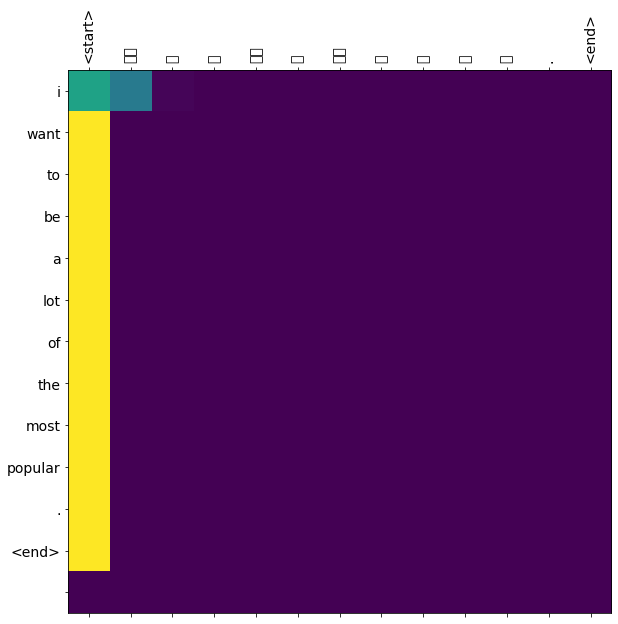

In [ ]:
translate(u'선생 님 이 문장 이 이해 가 안 가 요 .')

Input: <start> 나 는 일어나 자마자 화장실 에 가요 . <end>
Predicted translation: i want to be a lot of the most popular . <end> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_

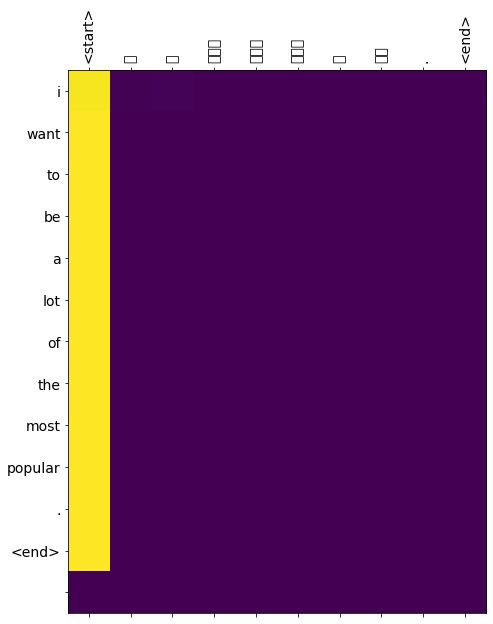

In [ ]:
translate(u'나 는 일어나 자마자 화장실 에 가요 .')

In [ ]:
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction
def sentences_to_bleu(ref, pred):
  """
  ref : 참고용 타겟 문장(학습용 영어 문장)
  pred : 예측 문장(번역 결과)
  """
  smoothie = SmoothingFunction().method4
  return bleu.sentence_bleu(ref, pred, smoothing_function=smoothie)

In [ ]:
import pandas as pd
news_df = pd.read_excel('kor.xlsx', sheet_name='Sheet1')
train_df, val_df, test_df = news_df.iloc[:50000, 1:], news_df.iloc[50000:63000, 1:], news_df.iloc[63000:, 1:]

In [ ]:
translate(u'나 는 일어나 자마자 화장실 에 가요 .')

In [ ]:
test_df.apply(lambda x : translate(u'{}'.format(x)))

KeyError: ignored